In [1]:
import os

import pandas as pd

In [2]:
# create .csv file_path from this folder "/Users/user/Documents/Coding/geo/notebook/data/crop_image"ArithmeticError
image_folder_path = (
    "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data/crop_image"
)
image_name_list = os.listdir(image_folder_path)
image_name_list = [
    image_name for image_name in image_name_list if not image_name.startswith(".")
]
image_path_list = [
    os.path.join(image_folder_path, image_name) for image_name in image_name_list
]
# create csv id,path,label
image_df = pd.DataFrame(
    {
        "id": [str(i) for i in range(len(image_path_list))],
        "path": image_path_list,
        "label": "no label",
    }
)
image_df.to_csv("./image.csv", index=False)

In [3]:
df_path = "./df_embedding.pkl"
df = pd.read_pickle(df_path)
df.head()

store_id      prov_namt   latitude   longitude  \
0      1025  กรุงเทพมหานคร  13.838724  100.575318   
1      1026       ปทุมธานี  14.036545  100.733520   
2      1028           ตรัง   7.567873   99.614094   
3      1032  กรุงเทพมหานคร  13.719625  100.442061   
4      1033  กรุงเทพมหานคร  13.768390  100.721288   

                                           embedding  
0  [-0.32667335867881775, 0.004393324255943298, 0...  
1  [-0.2123679518699646, -0.8437325358390808, 0.2...  
2  [-0.7250770330429077, -0.5593902468681335, 0.1...  
3  [-0.208128422498703, -0.6529959440231323, 0.03...  
4  [-0.48843494057655334, -0.732024610042572, -0....

In [4]:
# drop df if embedding is []
df = df[df["embedding"].map(lambda d: len(d)) > 0]
df.head()

store_id      prov_namt   latitude   longitude  \
0      1025  กรุงเทพมหานคร  13.838724  100.575318   
1      1026       ปทุมธานี  14.036545  100.733520   
2      1028           ตรัง   7.567873   99.614094   
3      1032  กรุงเทพมหานคร  13.719625  100.442061   
4      1033  กรุงเทพมหานคร  13.768390  100.721288   

                                           embedding  
0  [-0.32667335867881775, 0.004393324255943298, 0...  
1  [-0.2123679518699646, -0.8437325358390808, 0.2...  
2  [-0.7250770330429077, -0.5593902468681335, 0.1...  
3  [-0.208128422498703, -0.6529959440231323, 0.03...  
4  [-0.48843494057655334, -0.732024610042572, -0....

In [5]:
df.shape

(9997, 5)

In [6]:
import csv
from glob import glob
from pathlib import Path
from statistics import mean

from towhee import pipe, ops, DataCollection
from pymilvus import (
    connections,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    utility,
)


# Towhee parameters
MODEL = "maxvit_tiny_tf_512"
DEVICE = "mps"  # if None, use default device (cuda is enabled if available)

# Milvus parameters
HOST = "127.0.0.1"
PORT = "19530"
TOPK = 10
DIM = 512  # dimension of embedding extracted by MODEL
COLLECTION_NAME = "reverse_image_search"
INDEX_TYPE = "IVF_FLAT"
METRIC_TYPE = "L2"

# path to csv (column_1 indicates image path) OR a pattern of image paths
INSERT_SRC = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/image.csv"
QUERY_SRC = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data/crop_image/*.png"

In [25]:
# Load image path
def load_image(x):
    if x.endswith("csv"):
        with open(x) as f:
            reader = csv.reader(f)
            next(reader)
            for item in reader:
                yield item[1]
    else:
        for item in glob(x):
            yield item


# Embedding pipeline
p_embed = (
    pipe.input("src")
    .flat_map("src", "img_path", load_image)
    .map("img_path", "img", ops.image_decode())
    .map("img", "vec", ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
)


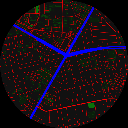

In [26]:
# Display embedding result, no need for implementation
p_display = p_embed.output("img_path", "img", "vec")
DataCollection(
    p_display(
        "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data/crop_image/1025.png"
    )
).show()

In [42]:
# Create milvus collection (delete first if exists)
def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        # if it has collection connect to it
        return Collection(name=collection_name)
        # utility.drop_collection(collection_name)

    fields = [
        FieldSchema(
            name="path",
            dtype=DataType.VARCHAR,
            description="path to image",
            max_length=500,
            is_primary=True,
            auto_id=False,
        ),
        FieldSchema(
            name="embedding",
            dtype=DataType.FLOAT_VECTOR,
            description="image embedding vectors",
            dim=dim,
        ),
    ]
    schema = CollectionSchema(fields=fields, description="reverse image search")
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        "metric_type": METRIC_TYPE,
        "index_type": INDEX_TYPE,
        "params": {"nlist": 2048},
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

In [43]:
# Connect to Milvus service
connections.connect(host=HOST, port=PORT)

# Create collection
collection = create_milvus_collection(COLLECTION_NAME, DIM)
print(f"A new collection created: {COLLECTION_NAME}")

A new collection created: reverse_image_search


In [44]:
# Insert pipeline
p_insert = p_embed.map(
    ("img_path", "vec"),
    "mr",
    ops.ann_insert.milvus_client(host=HOST, port=PORT, collection_name=COLLECTION_NAME),
).output("mr")

In [45]:
collection.num_entities

9997

In [46]:
# # Insert data
# p_insert(INSERT_SRC)

# # Check collection
# print("Number of data inserted:", collection.num_entities)

In [47]:
# Search pipeline
p_search_pre = (
    p_embed.map(
        "vec",
        ("search_res"),
        ops.ann_search.milvus_client(
            host=HOST, port=PORT, limit=TOPK, collection_name=COLLECTION_NAME
        ),
    ).map("search_res", "pred", lambda x: [str(Path(y[0]).resolve()) for y in x])
    #                .output('img_path', 'pred')
)
p_search = p_search_pre.output("img_path", "pred")

In [48]:
# Search for example query image(s)
collection.load()
dc = p_search(
    "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data/crop_image/2369.png"
)

# Display search results with image paths
DataCollection(dc).show()

In [49]:
# Display search results with images, no need for implementation
# Search pipeline
p_search_pre = (
    p_embed.map(
        "vec",
        ("search_res"),
        ops.ann_search.milvus_client(
            host=HOST,
            port=PORT,
            # limit=TOPK,
            limit=20,
            collection_name=COLLECTION_NAME,
        ),
    ).map("search_res", "pred", lambda x: [str(Path(y[0]).resolve()) for y in x])
    #                .output('img_path', 'pred')
)
p_search = p_search_pre.output("img_path", "pred")
import cv2
from towhee.types.image import Image


def read_images(img_paths):
    imgs = []
    for p in img_paths:
        imgs.append(Image(cv2.imread(p), "RGB"))
    return imgs


p_search_img = p_search_pre.map("pred", "pred_images", read_images).output(
    "img", "pred_images"
)
result = DataCollection(
    p_search_img(
        "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data/crop_image/2369.png"
    )
)


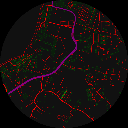
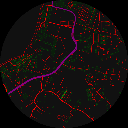
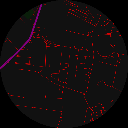
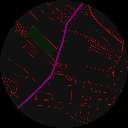
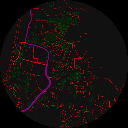
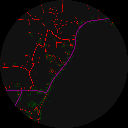
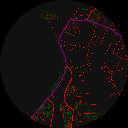
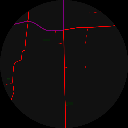
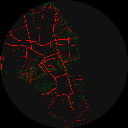
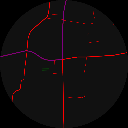
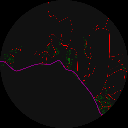
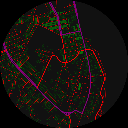
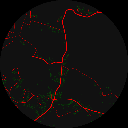
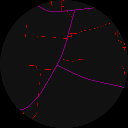
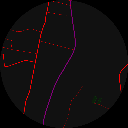
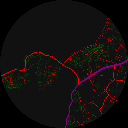
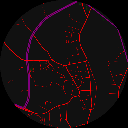
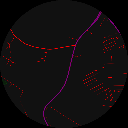
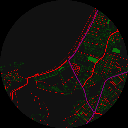
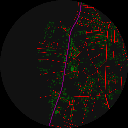
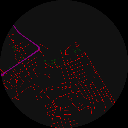

In [50]:
result.show()

In [51]:
result.__dict__

{'_schema': ['img', 'pred_images'],
 '_type_schema': [<ColumnType.QUEUE: 1>, <ColumnType.QUEUE: 1>],
 '_iterable': [<Entity dict_keys(['img', 'pred_images'])>]}

In [52]:
result_list = result.to_list()

In [53]:
for r in result_list:
    print(r.__dict__.keys())

dict_keys(['img', 'pred_images'])


In [54]:
# Search pipeline
p_search_pre = (
    p_embed.map(
        "vec",
        ("search_res"),
        ops.ann_search.milvus_client(
            host=HOST,
            port=PORT,
            limit=TOPK + 1,
            collection_name=COLLECTION_NAME,
        ),
    )
    .map("search_res", "pred", lambda x: [str(Path(y[0]).resolve()) for y in x])
    .map("search_res", "score", lambda x: [y[1] for y in x])
    #                .output('img_path', 'pred')
)
p_search = p_search_pre.output("pred", "score")

In [59]:
dc = p_search(
    "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data/crop_image/6813.png"
)
result = DataCollection(dc)
result.show()

In [60]:
result.__dict__

{'_schema': ['pred', 'score'],
 '_type_schema': [<ColumnType.QUEUE: 1>, <ColumnType.QUEUE: 1>],
 '_iterable': [<Entity dict_keys(['pred', 'score'])>]}

In [61]:
import pandas as pd

table_data = result.prepare_table_data()
print(table_data.keys())
table_data_dict = {}
for ind, key in enumerate(table_data["headers"]):
    table_data_dict[key] = table_data["data"][0][ind]
result_df = pd.DataFrame.from_dict(table_data_dict)
result_df

dict_keys(['data', 'headers'])


pred        score
0   /Users/user/Documents/Coding/cro_location_inte...     0.000000
1   /Users/user/Documents/Coding/cro_location_inte...  1475.657227
2   /Users/user/Documents/Coding/cro_location_inte...  2000.484619
3   /Users/user/Documents/Coding/cro_location_inte...  2068.846436
4   /Users/user/Documents/Coding/cro_location_inte...  2201.877930
5   /Users/user/Documents/Coding/cro_location_inte...  2237.388184
6   /Users/user/Documents/Coding/cro_location_inte...  2262.653076
7   /Users/user/Documents/Coding/cro_location_inte...  2265.844727
8   /Users/user/Documents/Coding/cro_location_inte...  2269.184082
9   /Users/user/Documents/Coding/cro_location_inte...  2289.122070
10  /Users/user/Documents/Coding/cro_location_inte...  2310.601562

In [62]:
def postprocess_df(df, result_df, max_num=TOPK):
    df = df.copy()
    result_df = result_df.copy()
    # drop first row
    result_df = result_df.iloc[1 : max_num + 1]
    # add new column file_name
    result_df["file_name"] = result_df["pred"].map(lambda x: x.split("/")[-1])
    # add new column store_id
    result_df["store_id"] = result_df["file_name"].map(lambda x: int(x.split(".")[0]))
    # store_id	prov_namt from df filter
    df = df[["store_id", "prov_namt"]]
    result_df = pd.merge(result_df, df, on="store_id", how="left")
    return result_df


new_df = postprocess_df(df, result_df)
new_df

pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1475.657227   7635.png   
1  /Users/user/Documents/Coding/cro_location_inte...  2000.484619  16493.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2068.846436  15616.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2201.877930  10638.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2237.388184  15291.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2262.653076  13461.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2265.844727   1420.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2269.184082   5761.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2289.122070   4661.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2310.601562   2550.png   

   store_id      prov_namt  
0      7635  กรุงเทพมหานคร  
1     16493    สมุทรปราการ  
2     15616    สมุทรปราการ  
3     10638  กรุงเทพมหานคร  
4     15291  กรุงเทพมหานคร  
5     13461       ปทุมธานี  
6      1420       ปทุมธานี  
7      5761  กรุงเทพมหานคร  
8      4661  กรุงเทพมหานคร  
9      2550        ราชบุรี

In [63]:
df["prov_namt"].value_counts()

กรุงเทพมหานคร    2687
ชลบุรี            733
นนทบุรี           506
สมุทรปราการ       454
ปทุมธานี          453
                 ... 
ยะลา                9
อำนาจเจริญ          8
ลำพูน               8
นราธิวาส            6
แม่ฮ่องสอน          5
Name: prov_namt, Length: 77, dtype: int64

In [64]:
import random

# set seed
random.seed(41)

In [65]:
# random select 3 from df["prov_namt"].unique()
random_prov_namt = random.sample(list(df["prov_namt"].unique()), 3)
random_prov_namt

['เลย', 'สุพรรณบุรี', 'จันทบุรี']

In [66]:
selected_province_list = [
    "กรุงเทพมหานคร",
    "กรุงเทพมหานคร",
    "นครราชสีมา",
    "ภูเก็ต",
    "ตราด",
    "ระนอง",
    "จันทบุรี",
]
selected_province_list += random_prov_namt
selected_province_list

['กรุงเทพมหานคร',
 'กรุงเทพมหานคร',
 'นครราชสีมา',
 'ภูเก็ต',
 'ตราด',
 'ระนอง',
 'จันทบุรี',
 'เลย',
 'สุพรรณบุรี',
 'จันทบุรี']

In [67]:
# random select index from df with province in selected_province_list
selected_store_id_list = []
for province in selected_province_list:
    print(province)
    candidate_store_id_list = list(df[df["prov_namt"] == province]["store_id"])
    selected_store_id_list += random.sample(candidate_store_id_list, 1)
selected_store_id_list

กรุงเทพมหานคร
กรุงเทพมหานคร
นครราชสีมา
ภูเก็ต
ตราด
ระนอง
จันทบุรี
เลย
สุพรรณบุรี
จันทบุรี


[4846, 10835, 11126, 11759, 5505, 8754, 16729, 1663, 6423, 1524]

In [68]:
image_folder_path

'/Users/user/Documents/Coding/cro_location_intelligence/notebook/data/crop_image'

In [69]:
df.iloc[1946]

store_id                                                  4875
prov_namt                                        กรุงเทพมหานคร
latitude                                             13.720453
longitude                                           100.501732
embedding    [0.03810449317097664, -0.6218857765197754, 0.3...
Name: 1946, dtype: object

In [88]:
result_dict_list = []
for selected_store_id in selected_store_id_list:
    store_id = selected_store_id
    #
    store_id = 7025
    province = df[df["store_id"] == store_id]["prov_namt"].values[0]
    print(store_id)
    image_path = os.path.join(image_folder_path, f"{store_id}.png")
    dc = p_search(image_path)
    result = DataCollection(dc)
    table_data = result.prepare_table_data()
    table_data_dict = {}
    for ind, key in enumerate(table_data["headers"]):
        table_data_dict[key] = table_data["data"][0][ind]
    result_df = pd.DataFrame.from_dict(table_data_dict)
    result_df = postprocess_df(df, result_df)
    result_dict = {}
    result_dict["store_id"] = store_id
    result_dict["df"] = result_df
    result_dict["province"] = province
    result_dict["image_path"] = image_path
    result_dict_list.append(result_dict)

7025
7025
7025
7025
7025
7025
7025
7025
7025
7025


In [89]:
# create empty df for concat
result_df = pd.DataFrame()
for result_dict in result_dict_list:
    each_df = result_dict["df"]
    print(result_dict["store_id"])
    print(result_dict["province"])
    display(each_df)
    print()

    each_df = each_df.copy()
    # drop pred
    each_df = each_df.drop(columns=["pred"])
    each_df = each_df.drop(columns=["file_name"])

    each_df["target_store_id"] = result_dict["store_id"]
    each_df["target_province"] = result_dict["province"]

    # rearrange columns
    each_df = each_df[
        [
            "target_store_id",
            "target_province",
            "store_id",
            "prov_namt",
            "score",
        ]
    ]
    result_df = pd.concat([result_df, each_df])
    # break
save_file_name = f"result.xlsx"
save_file_path = os.path.join("./p_jit/", save_file_name)
result_df.to_excel(save_file_path, index=False)
result_df

7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี


7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี


7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี


7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี


7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี


7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี


7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี


7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี


7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี


7025
นครนายก


pred        score  file_name  \
0  /Users/user/Documents/Coding/cro_location_inte...  1179.995850   8030.png   
1  /Users/user/Documents/Coding/cro_location_inte...  1667.887573    564.png   
2  /Users/user/Documents/Coding/cro_location_inte...  2288.518799  13461.png   
3  /Users/user/Documents/Coding/cro_location_inte...  2298.034180   1021.png   
4  /Users/user/Documents/Coding/cro_location_inte...  2511.969238   7381.png   
5  /Users/user/Documents/Coding/cro_location_inte...  2522.890625   7170.png   
6  /Users/user/Documents/Coding/cro_location_inte...  2559.941162  17940.png   
7  /Users/user/Documents/Coding/cro_location_inte...  2562.816895   9960.png   
8  /Users/user/Documents/Coding/cro_location_inte...  2676.458740  13022.png   
9  /Users/user/Documents/Coding/cro_location_inte...  2720.562012  15047.png   

   store_id     prov_namt  
0      8030       นครนายก  
1       564       นครนายก  
2     13461      ปทุมธานี  
3      1021           NaN  
4      7381        นครปฐม  
5      7170         ชุมพร  
6     17940           NaN  
7      9960      ปทุมธานี  
8     13022    ฉะเชิงเทรา  
9     15047  สุราษฎร์ธานี

target_store_id target_province  store_id     prov_namt        score
0              7025         นครนายก      8030       นครนายก  1179.995850
1              7025         นครนายก       564       นครนายก  1667.887573
2              7025         นครนายก     13461      ปทุมธานี  2288.518799
3              7025         นครนายก      1021           NaN  2298.034180
4              7025         นครนายก      7381        นครปฐม  2511.969238
..              ...             ...       ...           ...          ...
5              7025         นครนายก      7170         ชุมพร  2522.890625
6              7025         นครนายก     17940           NaN  2559.941162
7              7025         นครนายก      9960      ปทุมธานี  2562.816895
8              7025         นครนายก     13022    ฉะเชิงเทรา  2676.458740
9              7025         นครนายก     15047  สุราษฎร์ธานี  2720.562012

[100 rows x 5 columns]

In [90]:
approval_authority_dict = {
    30_000: "DM",
    50_000: "GM",
    100_000: "AVP",
    200_000: "VP",
    500_000: "SVP",
    2_000_000: "EVP",
    4_000_000: "COO",
}


def calculate_approval_level(series, approval_authority_dict) -> pd.Series:
    result_series = series.apply(
        lambda x: next(
            (
                approval_authority_dict[amount]
                for amount in sorted(approval_authority_dict.keys())
                if x <= amount
            ),
            "CEO",
        )
    )
    return result_series


# mockup data
series = pd.Series(
    [1000, 30000, 50000, 100000, 200000, 500000, 2000000, 4000000, 5000000, 10000000]
)
calculate_approval_level(series, approval_authority_dict)

0     DM
1     DM
2     GM
3    AVP
4     VP
5    SVP
6    EVP
7    COO
8    CEO
9    CEO
dtype: object

7025
นครนายก
score : 1179.995849609375
prov_namt : นครนายก


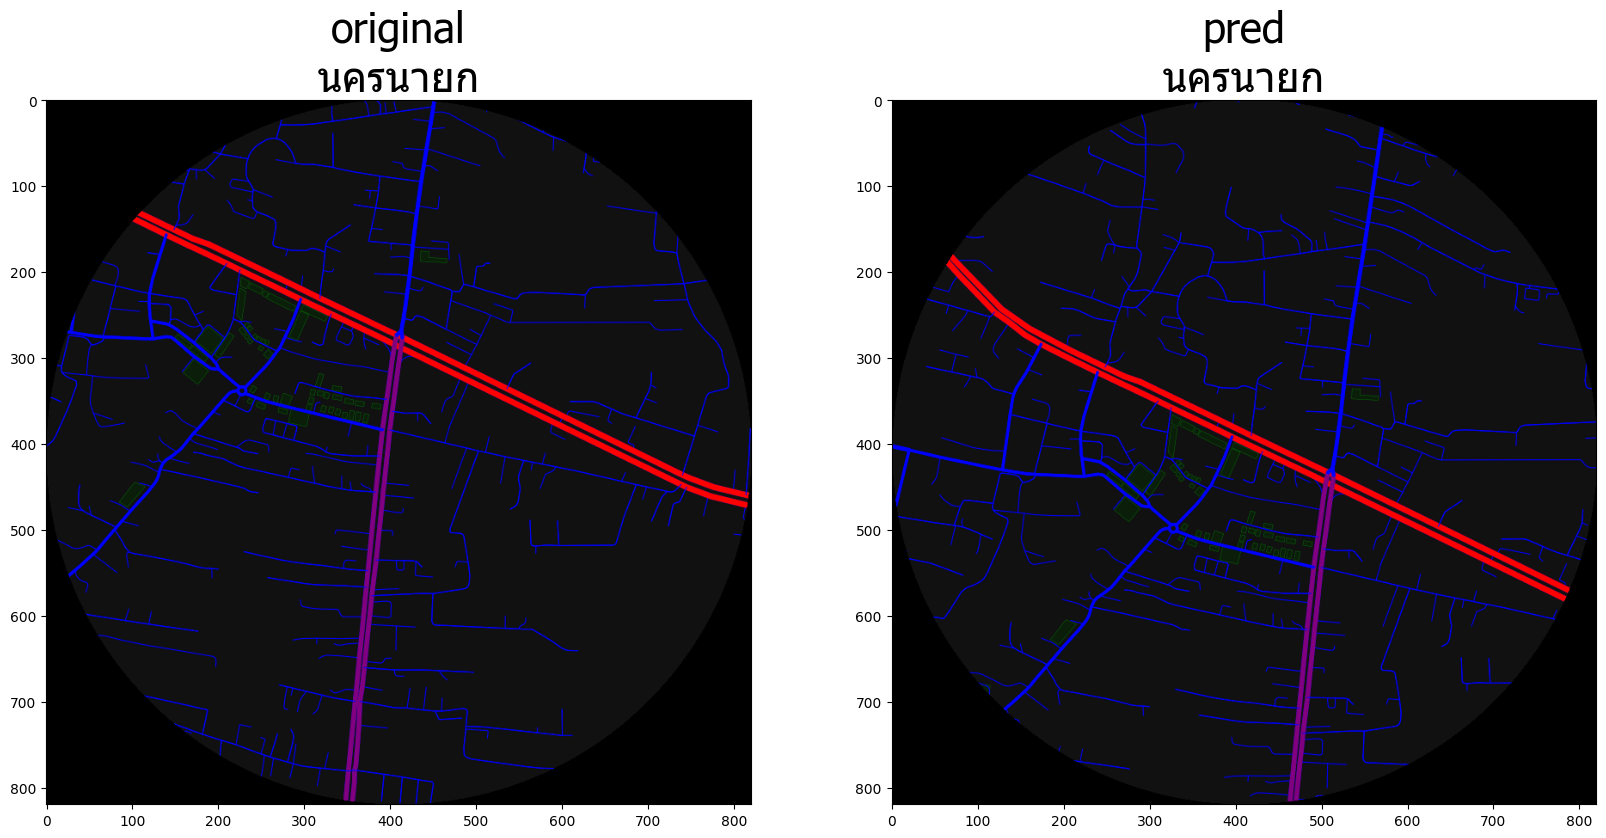

score : 1667.8875732421875
prov_namt : นครนายก


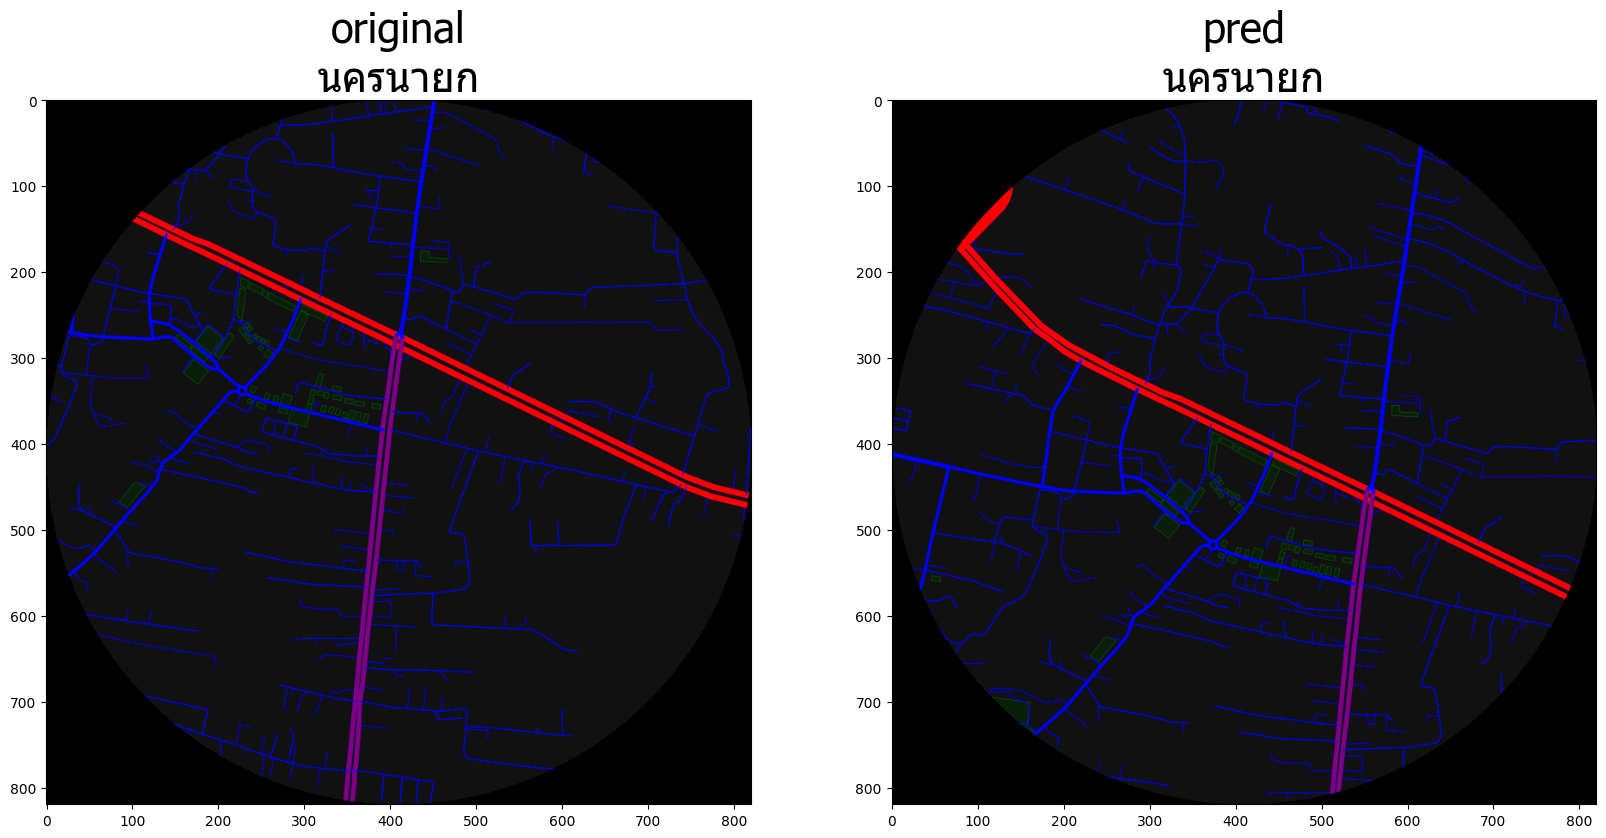

score : 2288.518798828125
prov_namt : ปทุมธานี


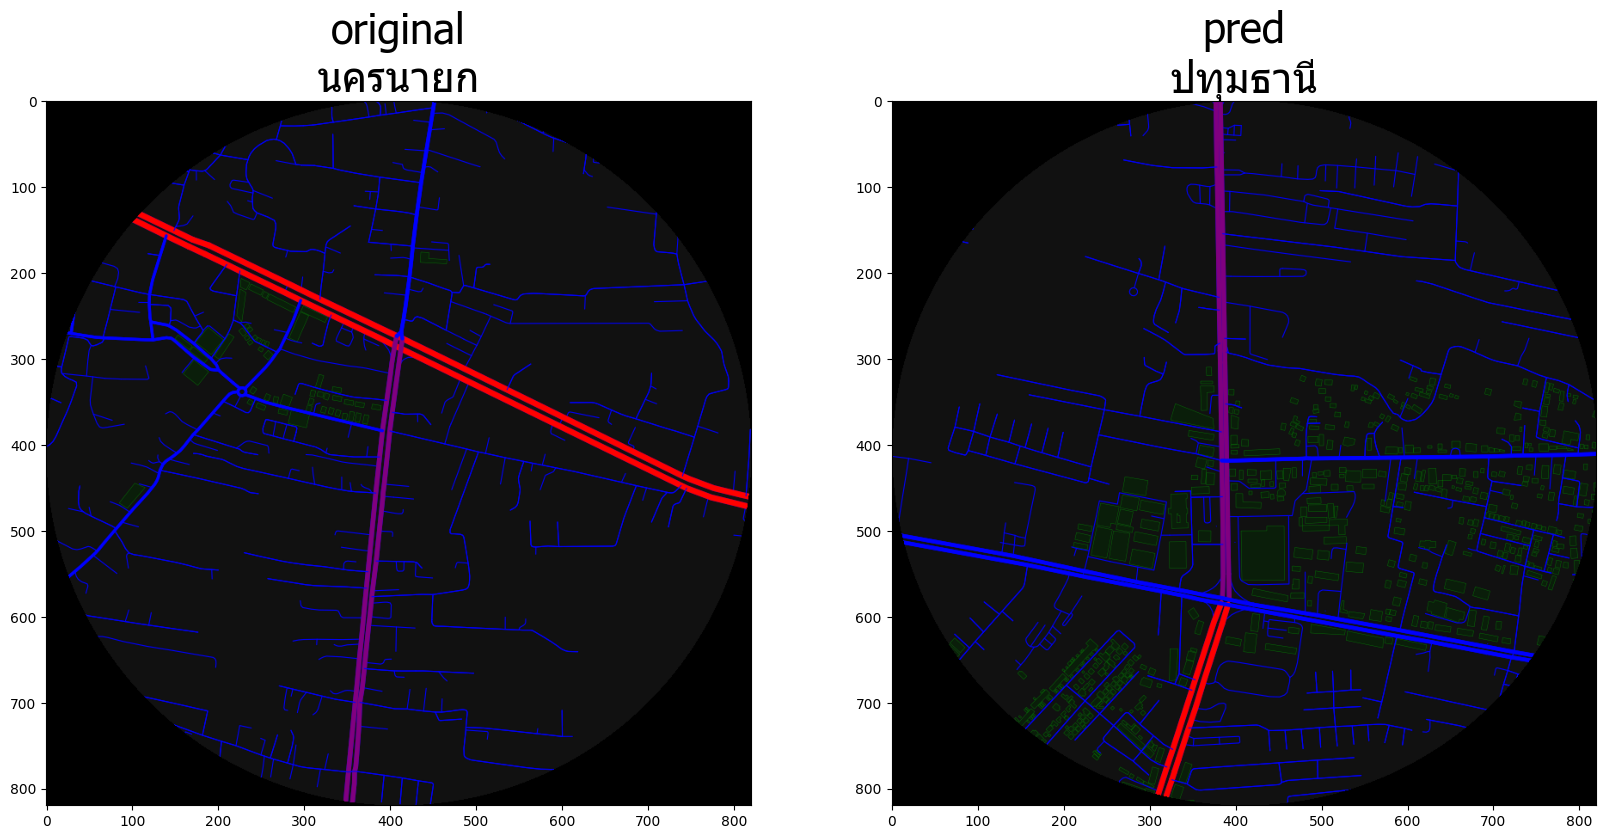

score : 2298.0341796875
prov_namt : nan


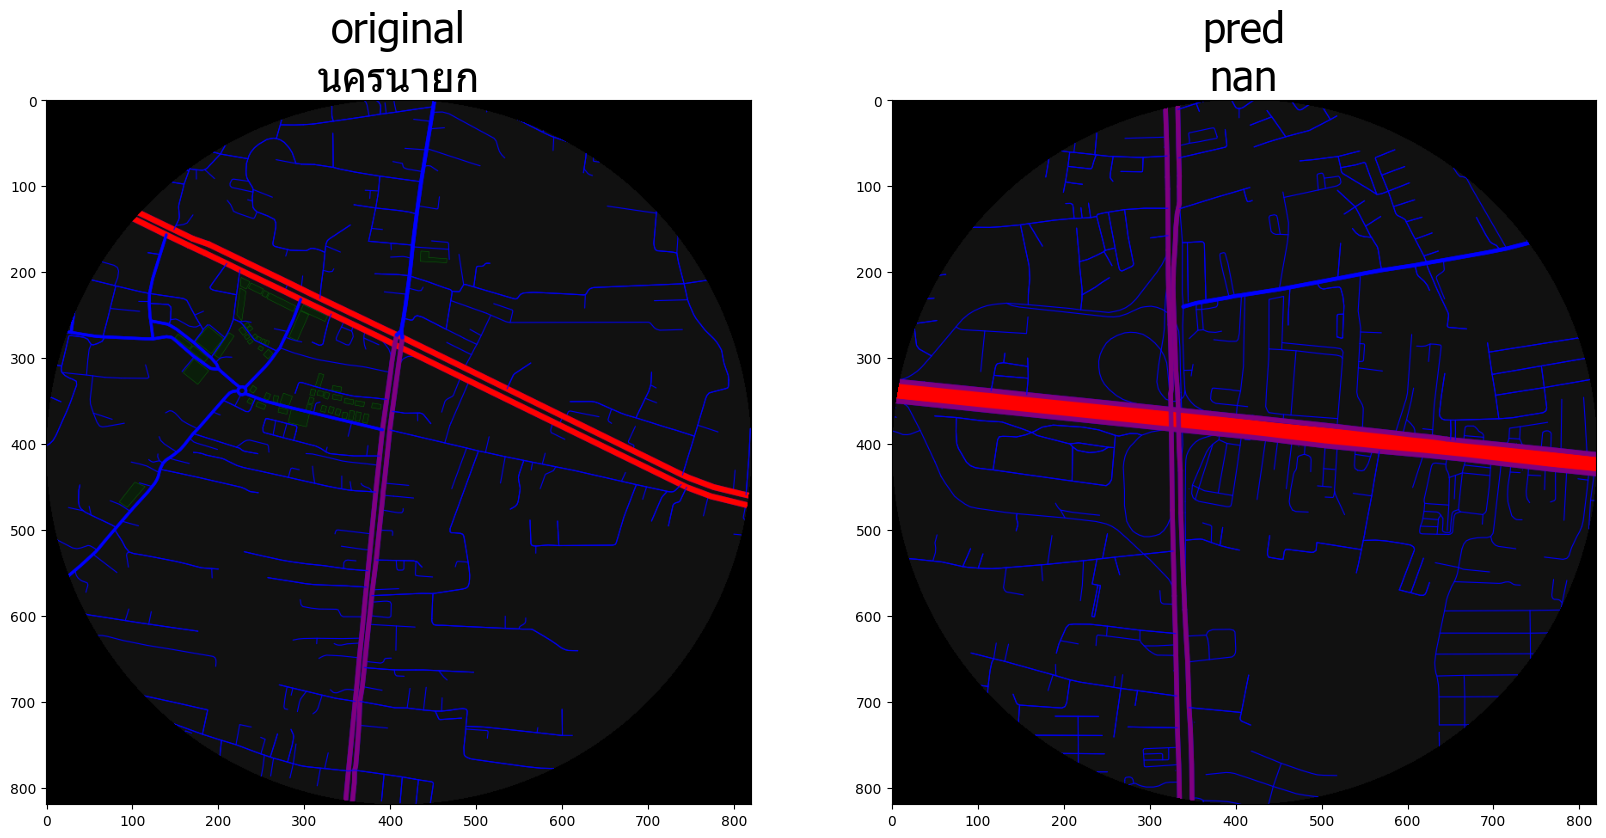

score : 2511.96923828125
prov_namt : นครปฐม


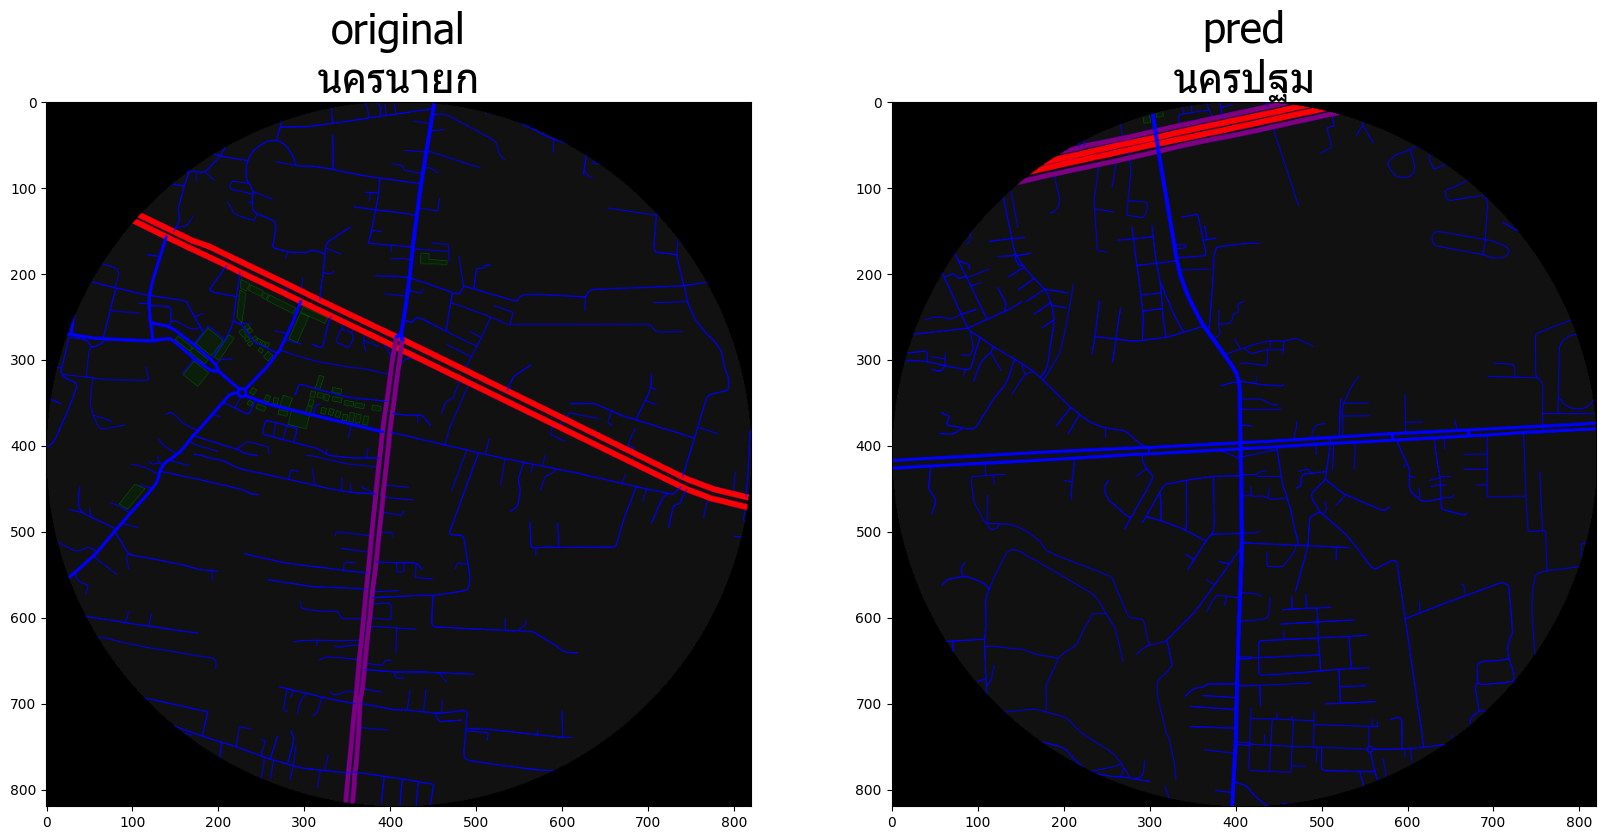

score : 2522.890625
prov_namt : ชุมพร


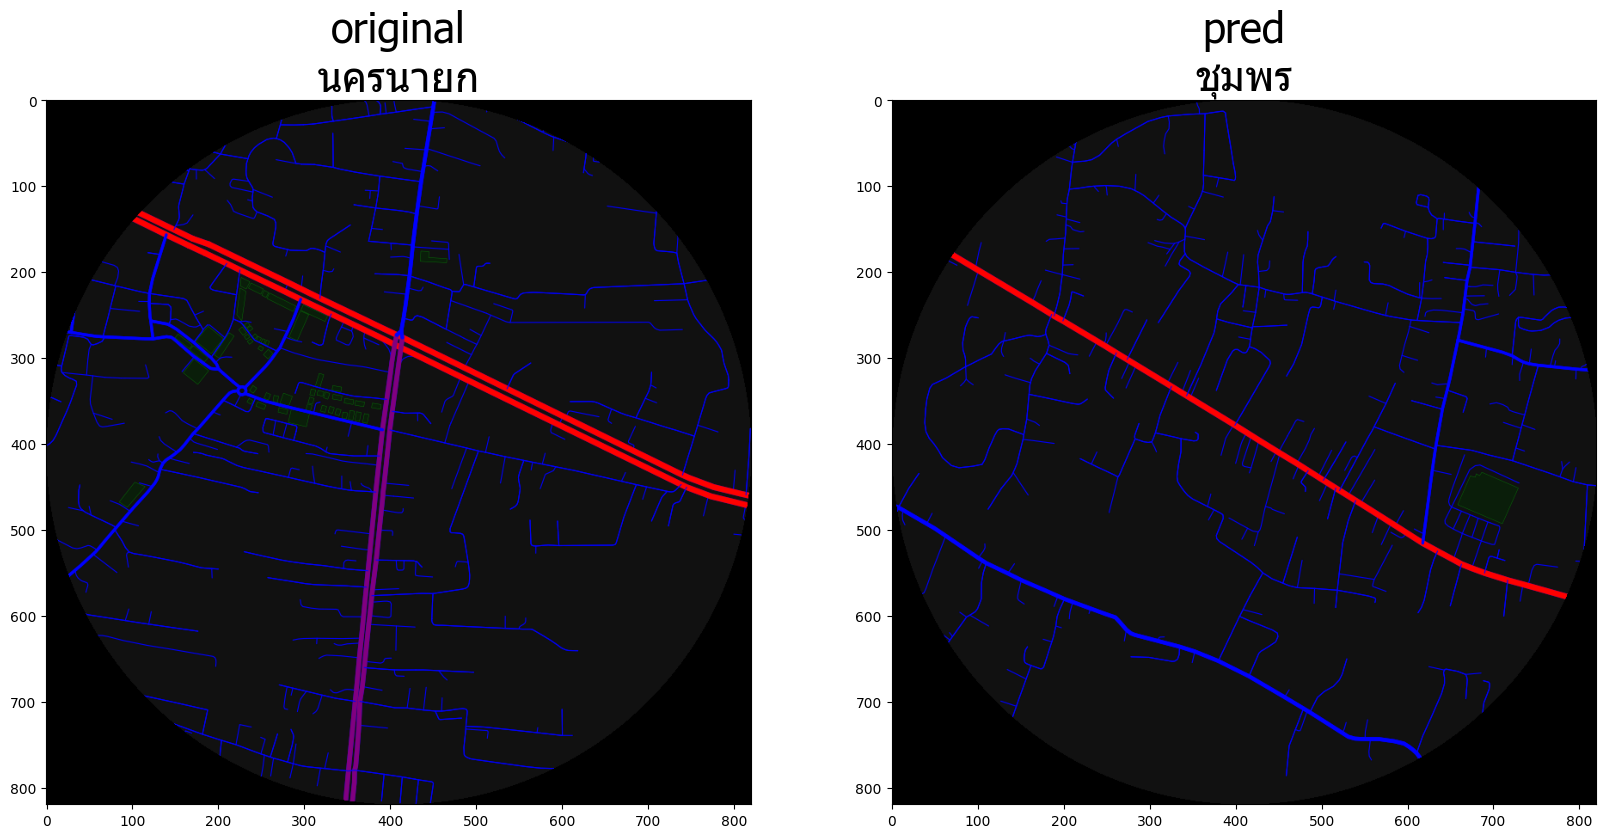

score : 2559.941162109375
prov_namt : nan


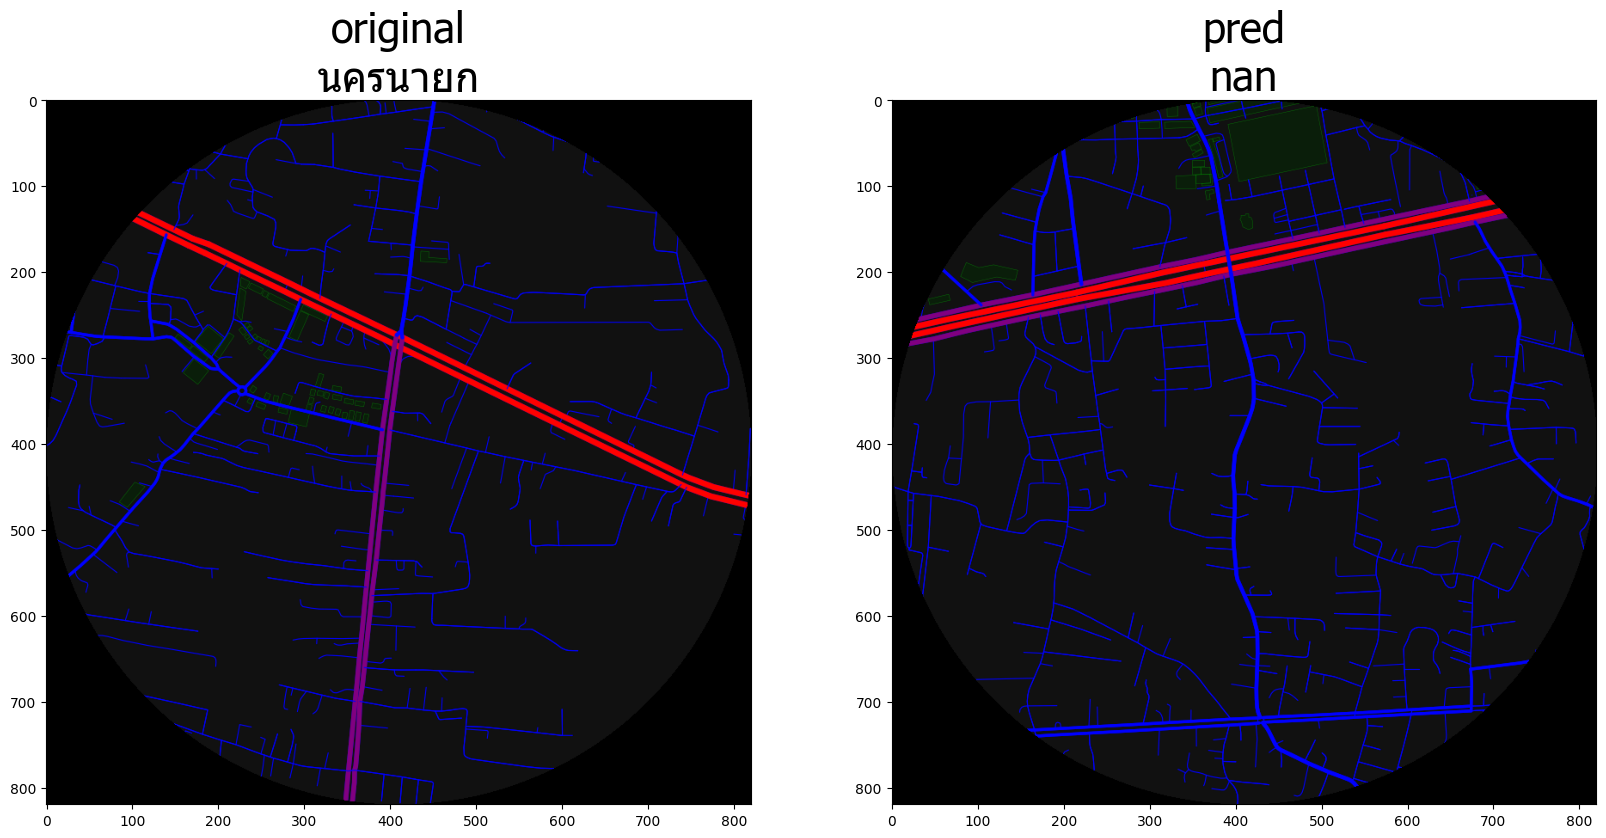

score : 2562.81689453125
prov_namt : ปทุมธานี


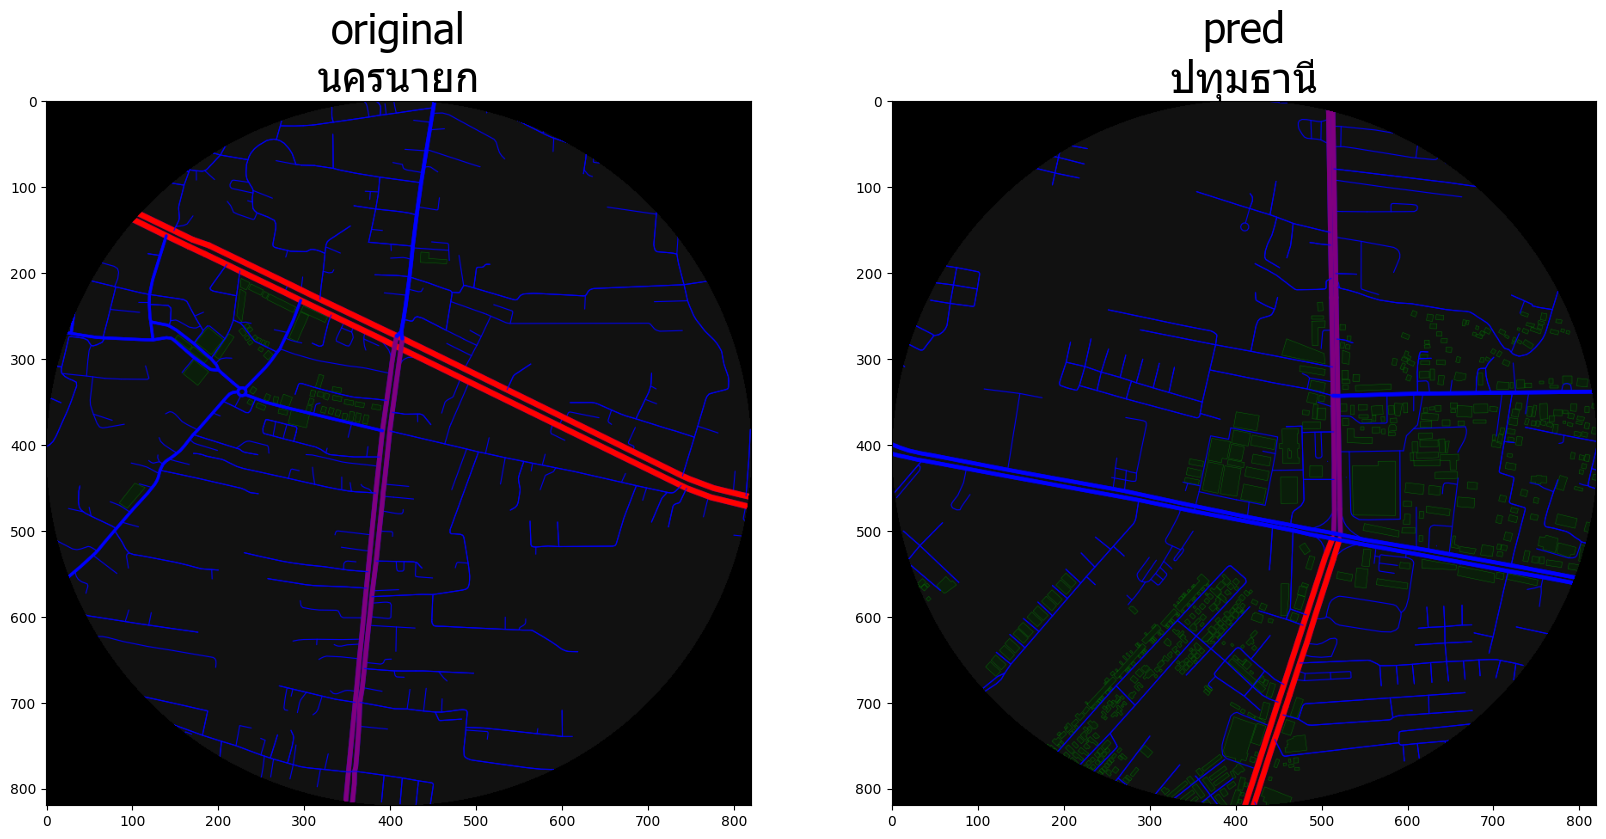

score : 2676.458740234375
prov_namt : ฉะเชิงเทรา


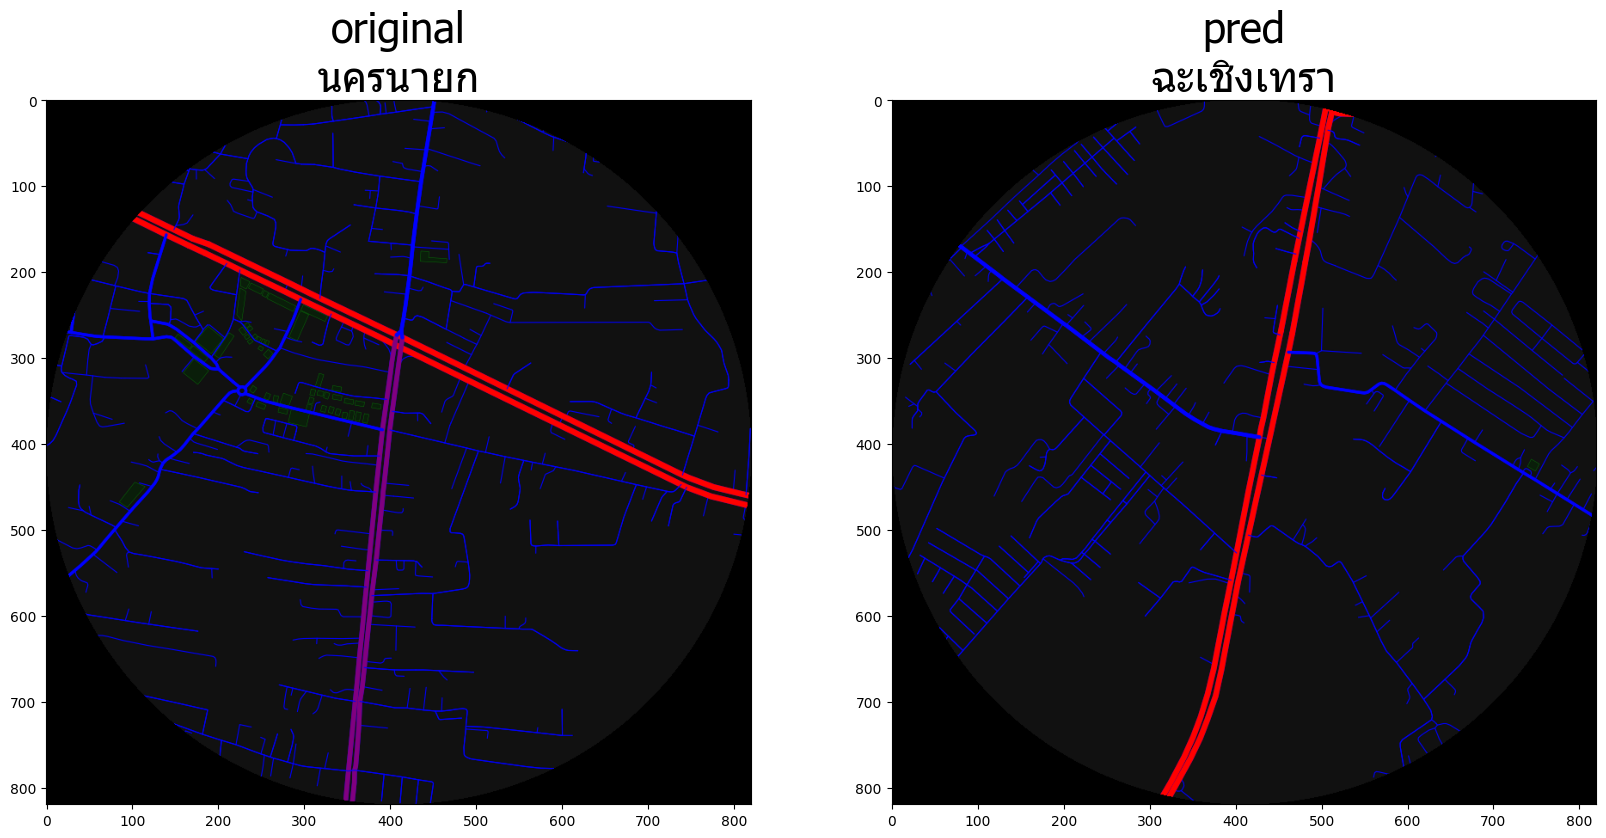

score : 2720.56201171875
prov_namt : สุราษฎร์ธานี


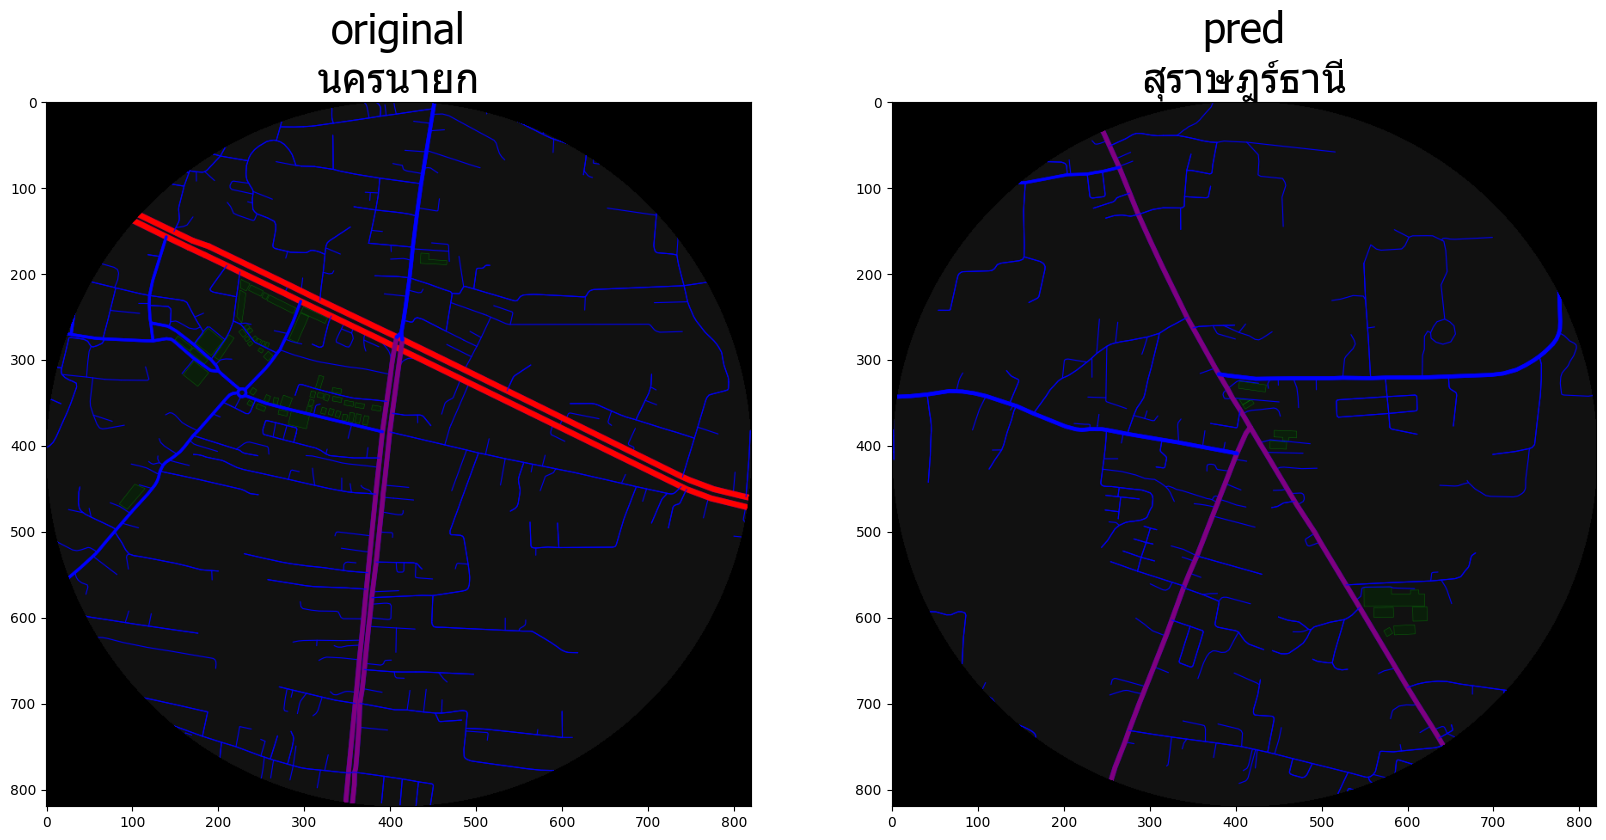

In [91]:
from PIL import Image
import matplotlib.pyplot as plt


def display_images(
    image_a,
    image_b,
    label_a,
    label_b,
    size=10,
    font_size=30,
    font_family="tahoma",
    save_path=None,
):
    # Create a 1x2 subplot grid
    plt.figure(figsize=(size * 2, size))

    # Plot the first image on the left
    plt.subplot(1, 2, 1)
    plt.imshow(image_a)
    plt.title(label_a, fontdict={"fontsize": font_size, "family": font_family})
    # plt.xlabel(score : 770.4474487304688"X-axis Label", fontdict={"fontsize": font_size, "family": font_family})

    # Plot the second image on the right
    plt.subplot(1, 2, 2)
    plt.imshow(image_b)
    plt.title(label_b, fontdict={"fontsize": font_size, "family": font_family})

    # Set font for x and y axis labels
    # plt.ylabel("Y-axis Label", fontdict={"fontsize": font_size, "family": font_family})

    # Adjust layout for better spacing
    # plt.tight_layout()

    # Show the plot
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


def display_pred_from_result_dict(result_dict, size=10):
    df = result_dict["df"]
    print(result_dict["store_id"])
    print(result_dict["province"])
    original_image_path = result_dict["image_path"]
    ori_image = Image.open(original_image_path)

    pred = df["pred"].values
    for ind, p in enumerate(pred):
        score = df["score"].values[ind]
        prov_namt = df["prov_namt"].values[ind]
        print(f"score : {score}")
        print(f"prov_namt : {prov_namt}")
        image = Image.open(p)
        display_images(
            ori_image,
            image,
            f"original\n{result_dict['province']}",
            f"pred\n{prov_namt}",
            size=size,
            save_path=f"./p_jit/{result_dict['store_id']}_{ind}.png",
        )

        # break


result_dict = result_dict_list[0]

# break
display_pred_from_result_dict(result_dict)